# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

# Table of Contents

    1. Load Data and artificial dataset construction
       1.1 Load data
       1.2 IR inspection
       1.3 Artificial dataset Construction
    2. Data clean and EDA
       2.1 Numerical feature clean and EDA
       2.2 Categorical features clean and EDA
    3. Splitting data and Feature Engineering
       3.1 Split data
       3.2 Feature engineer
           3.2.1 Standardise numerical variables
           3.2.2 Target encoding categorical variables
    4. Obtain resampling data
    5. Model training
       5.1 Random forest
       5.2 Neural network
       5.3 Logit
           5.3.1 Logit training
           5.3.2 Apply resampling methods on Logit
       5.4 XGBoost
           5.4.1 XGBoost training
           5.4.2 Apply resampling methods on XGBoost
    6. XAI
       6.1 Calculate rank correlation threshold with boostrap
           6.1.1 SHAP threshold
           6.1.2 PFI threshold
       6.2 SHAP fearure importance
           6.2.1 Calculate SHAP feature importance
           6.2.2 SHAP rank correlation
           6.2.3 SHAP feature importance visualisation
       6.3 PFI
           6.3.1 Calculate PFI
           6.3.2 PFI rank correlation
           6.3.3 PFI feature importance visualisation

In [1]:
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

In [2]:
# Inspecting dataport libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)


%load_ext autoreload
%autoreload 2

# 1. Load Data and artificial dataset construction

## 1.1 Load data

In [3]:
#read df
ucig_ori= pd.read_csv("../data/german.data", 
                     sep=' ',header=None)

#change column names
ucig_ori.columns = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 
         'target']

print(ucig_ori.shape)
print(ucig_ori.info())

(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   existingchecking       1000 non-null   object
 1   duration               1000 non-null   int64 
 2   credithistory          1000 non-null   object
 3   purpose                1000 non-null   object
 4   creditamount           1000 non-null   int64 
 5   savings                1000 non-null   object
 6   employmentsince        1000 non-null   object
 7   installmentrate        1000 non-null   int64 
 8   statussex              1000 non-null   object
 9   otherdebtors           1000 non-null   object
 10  residencesince         1000 non-null   int64 
 11  property               1000 non-null   object
 12  age                    1000 non-null   int64 
 13  otherinstallmentplans  1000 non-null   object
 14  housing                1000 non-null   object
 15  existingcre

## 1.2 IR inspection

In [4]:
ucig_ori.target.replace([1,2], [0,1], inplace=True)
ucig_ori.target.value_counts()

0    700
1    300
Name: target, dtype: int64

In [5]:
IR_ori = round(len(ucig_ori.loc[ucig_ori['target'] == 0])/len(ucig_ori.loc[ucig_ori['target'] == 1]),2)
print('The imbalance ratio of the original data set is '+ str(IR_ori))

The imbalance ratio of the original data set is 2.33


<AxesSubplot:ylabel='target'>

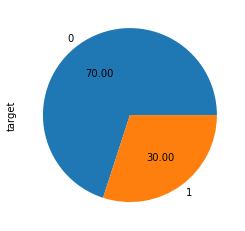

In [6]:
ucig_ori.target.value_counts().plot.pie(autopct = "%.2f")

## 1.3 Artificial dataset Construction

In [7]:
minority = ucig_ori[ucig_ori['target']==1]
majority = ucig_ori[ucig_ori['target']==0]

In [8]:
#randomly remove minority class to achieve IR=20
np.random.seed(10)
remove_n = int(minority.shape[0] - majority.shape[0]/20)
drop_indices = np.random.choice(minority.index, remove_n, replace=False)
minority_art = minority.drop(drop_indices)
print(minority_art.shape)

(35, 21)


In [9]:
#obtain constructed artifical data set
ucig = pd.concat([majority, minority_art])
IR_art = round(len(ucig.loc[ucig['target'] == 0])/len(ucig.loc[ucig['target'] == 1]),2)

print(ucig.shape)
print(ucig.target.value_counts())
print('The imbalance ratio of artificial data set is '+ str(IR_art))

(735, 21)
0    700
1     35
Name: target, dtype: int64
The imbalance ratio of artificial data set is 20.0


# 2. Data clean and EDA

## 2.1 Numerical feature clean and EDA

In [10]:
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable']
ucig[numvars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 979
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   creditamount     735 non-null    int64
 1   duration         735 non-null    int64
 2   installmentrate  735 non-null    int64
 3   residencesince   735 non-null    int64
 4   age              735 non-null    int64
 5   existingcredits  735 non-null    int64
 6   peopleliable     735 non-null    int64
dtypes: int64(7)
memory usage: 45.9 KB


### Check the missing values

In [11]:
print(ucig[numvars].isnull().sum() )

creditamount       0
duration           0
installmentrate    0
residencesince     0
age                0
existingcredits    0
peopleliable       0
dtype: int64


### EDA

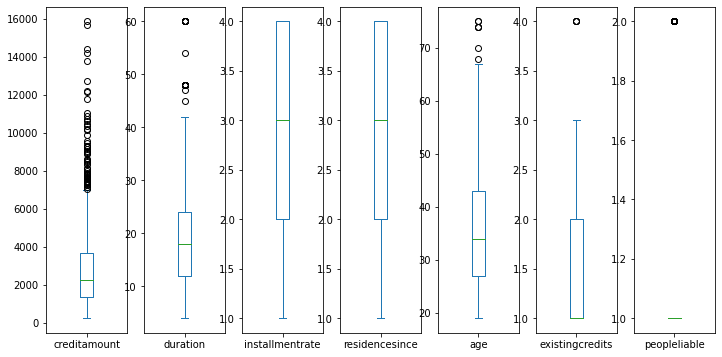

In [12]:
#check the distribution and outliers
plt.rcParams["figure.figsize"] = (12,6)
num_vars = ucig[numvars]
num_vars.plot(kind = 'box', subplots=True);

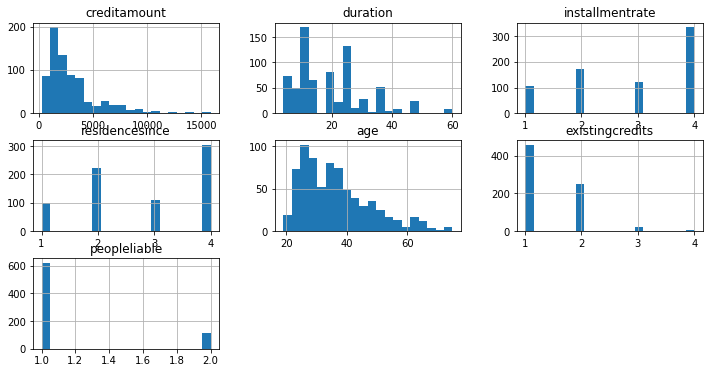

In [13]:
ucig[numvars].hist(bins=20);

### Check the correlation

In [14]:
all_num = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'target']

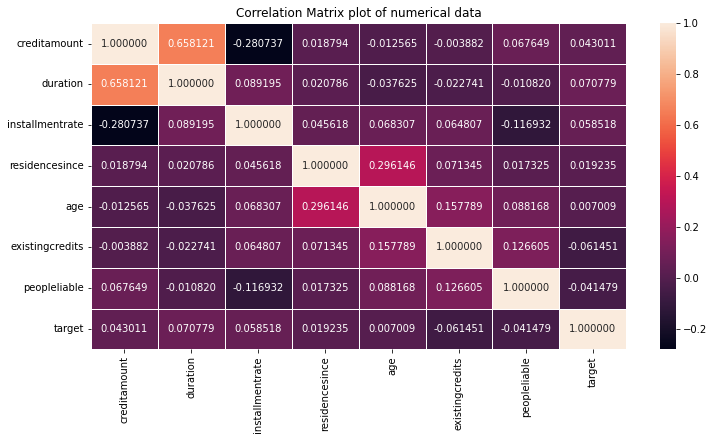

In [15]:
sns.heatmap(ucig[all_num].corr(),annot=True,linewidth=.5,fmt='1f')
plt.title('Correlation Matrix plot of numerical data')
plt.show()

## 2.2 Categorical features clean and EDA

In [16]:
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing',
           'job', 'telephone', 'foreignworker']

In [17]:
#change data type
ucig[catvars] = ucig[catvars].astype('category') 

### Check missing value

In [18]:
print(ucig[catvars].isnull().sum())

existingchecking         0
credithistory            0
purpose                  0
savings                  0
employmentsince          0
statussex                0
otherdebtors             0
property                 0
otherinstallmentplans    0
housing                  0
job                      0
telephone                0
foreignworker            0
dtype: int64


### Check categorical levels and disribution

In [19]:
for cat in catvars:
    print(ucig[cat].value_counts())

A14    351
A12    178
A11    157
A13     49
Name: existingchecking, dtype: int64
A32    381
A34    247
A33     63
A31     24
A30     20
Name: credithistory, dtype: int64
A43     224
A40     156
A42     128
A41      89
A49      67
A46      32
A45      15
A44       9
A48       8
A410      7
Name: purpose, dtype: int64
A61    409
A65    156
A62     74
A63     53
A64     43
Name: savings, dtype: int64
A73    245
A75    199
A74    141
A72    109
A71     41
Name: employmentsince, dtype: int64
A93    419
A92    214
A94     70
A91     32
Name: statussex, dtype: int64
A101    668
A103     42
A102     25
Name: otherdebtors, dtype: int64
A123    243
A121    231
A122    167
A124     94
Name: property, dtype: int64
A143    621
A141     83
A142     31
Name: otherinstallmentplans, dtype: int64
A152    551
A151    116
A153     68
Name: housing, dtype: int64
A173    469
A172    146
A174    105
A171     15
Name: job, dtype: int64
A191    430
A192    305
Name: telephone, dtype: int64
A201    701
A202    

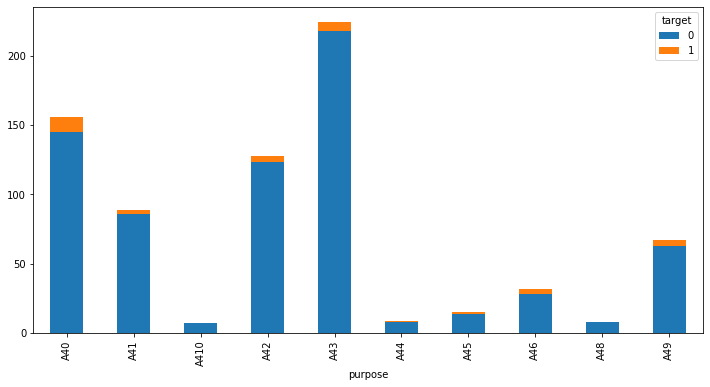

In [20]:
purpose = ucig.groupby(['target', 'purpose']).size().reset_index().pivot(columns='target', index='purpose', values=0)
purpose.plot(kind='bar', stacked=True);

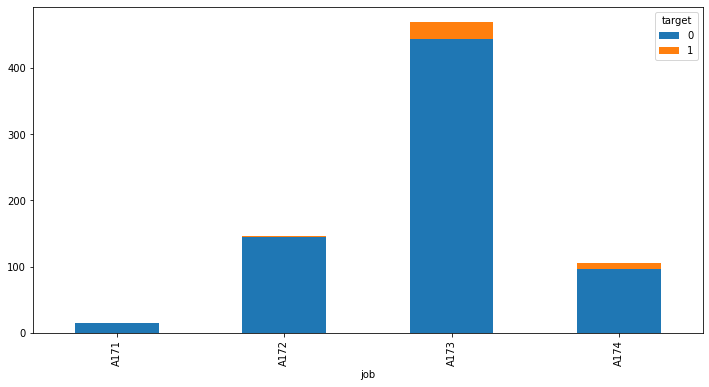

In [21]:
job = ucig.groupby(['target', 'job']).size().reset_index().pivot(columns='target', index='job', values=0)
job.plot(kind='bar', stacked=True);

# 3. Splitting data and Feature Engineering

## 3.1 Splitting data

In [22]:
y = ucig['target']
X = ucig.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2,shuffle=True, random_state= 1)

## 3.2 Feature engineer

### 3.2.1 Standardise numerical variables

In [23]:
standard = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numvars] = standard.fit_transform(X_train_scaled[numvars])
X_val_scaled[numvars] = standard.transform(X_val_scaled[numvars])

X_val_scaled[numvars].head()

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable
768,0.260732,-0.644112,-1.717582,1.042085,-0.731002,2.726312,-0.416717
907,0.299416,1.477174,-0.833996,-0.757463,-0.819608,-0.713755,-0.416717
219,-0.666454,-0.820886,-0.833996,1.042085,2.458824,-0.713755,-0.416717
497,-0.575505,0.416531,0.933174,0.142311,0.332273,1.006278,-0.416717
758,-0.654520,0.416531,-0.833996,-0.757463,-0.465183,-0.713755,-0.416717


### 3.2.2 Target encoding categorical variables

In [24]:
TE_encoder = TargetEncoder()
X_train_te = TE_encoder.fit_transform(X_train[catvars], y_train)
X_val_te = TE_encoder.transform(X_val[catvars])
print(X_train_te.head())

     existingchecking  credithistory   purpose   savings  employmentsince  \
101          0.073826       0.050505  0.021622  0.051829         0.025424   
269          0.003571       0.050505  0.021622  0.040000         0.060606   
453          0.003571       0.050505  0.043478  0.051829         0.060606   
189          0.073826       0.263158  0.030612  0.051829         0.036842   
556          0.073826       0.263158  0.073171  0.066667         0.060976   

     statussex  otherdebtors  property  otherinstallmentplans   housing  \
101   0.041667      0.046816  0.040404               0.050505  0.081395   
269   0.041667      0.046816  0.040404               0.050505  0.036036   
453   0.041667      0.046816  0.040404               0.050505  0.036036   
189   0.053254      0.046816  0.040404               0.000000  0.036036   
556   0.053254      0.046816  0.040404               0.050505  0.036036   

          job  telephone  foreignworker  
101  0.048128   0.048571       0.046429  
26

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [25]:
#concat
X_train_final = pd.concat([X_train_scaled[numvars],X_train_te], axis=1)
X_val_final = pd.concat([X_val_scaled[numvars],X_val_te], axis=1)

# 4. Obtain resampling data

In [26]:
def resampling(ratio=1):
    X_data_list = []
    y_data_list = []
    for single_class in classes:
        if single_class == NearMiss:
            instance = single_class(sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))  
        else:
            instance = single_class(random_state=40, sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))       
    return X_data_list, y_data_list

In [27]:
classes = [RandomOverSampler, SMOTE, BorderlineSMOTE,
           RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
           SMOTEENN, SMOTETomek]

#IR=1
X_data_list1, y_data_list1 = resampling(1)

print(len(X_data_list1),len(y_data_list1))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 1 completed
Resampled dataset shape Counter({0: 561, 1: 561})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 1 completed
Resampled dataset shape Counter({0: 561, 1: 561})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 1 completed
Resampled dataset shape Counter({0: 561, 1: 561})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 1 completed
Resampled dataset shape Counter({0: 27, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 1 completed
Resampled dataset shape Counter({0: 27, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 1 completed
Resampled dataset shape Counter({0: 135, 1: 27})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 1 completed
Resampled dataset shape Counter({1: 520, 0: 418})
<class 'imblearn.combin

In [28]:
#IR=5
X_data_list2, y_data_list2 = resampling(0.2)

print(len(X_data_list2),len(y_data_list2))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 561, 1: 112})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 561, 1: 112})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 561, 1: 112})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 135, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.2 completed
Resampled dataset shape Counter({0: 135, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.2 completed
Resampled dataset shape Counter({0: 135, 1: 27})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.2 completed
Resampled dataset shape Counter({0: 465, 1: 57})
<class '

In [29]:
#IR=10
X_data_list3, y_data_list3 = resampling(0.1)

print(len(X_data_list3),len(y_data_list3))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 561, 1: 56})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 561, 1: 56})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 561, 1: 56})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 270, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.1 completed
Resampled dataset shape Counter({0: 270, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.1 completed
Resampled dataset shape Counter({0: 291, 1: 27})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.1 completed
Resampled dataset shape Counter({0: 484, 1: 9})
<class 'imbl

In [30]:
#IR=15
X_data_list4, y_data_list4 = resampling(0.0667)

print(len(X_data_list4),len(y_data_list4))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 561, 1: 37})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 561, 1: 37})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 561, 1: 37})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 404, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.0667 completed
Resampled dataset shape Counter({0: 404, 1: 27})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.0667 completed
Resampled dataset shape Counter({0: 415, 1: 27})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.0667 completed
Resampled dataset shape Counter({0: 498

# 5. Model training

## 5.1 Random forest

In [31]:
#perform hyper parameter grid search
rf = RandomForestClassifier(random_state=0)                      
param_grid = {'n_estimators': [25, 50, 100],
              'max_features': [2, 4, 8]
              }

gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=0)
gs_rf.fit(X_train_final, y_train.values.ravel())                      

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': [2, 4, 8],
                         'n_estimators': [25, 50, 100]},
             scoring='roc_auc')

In [32]:
rf_tune = gs_rf.best_estimator_
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
print(rf_tune)

Best CV AUC: 0.7887
Optimal RF meta-parameters:
{'max_features': 2, 'n_estimators': 100}
RandomForestClassifier(max_features=2, random_state=0)


In [33]:
from function import evaluation
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,rf_tune)
rf_eva = ['RF', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
rf_eva

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


['RF', 1.0, 0.52, 0.0, 0.0, 0.0, 0.0]

## 5.2 neural network

In [34]:
# Define model
model = keras.Sequential([ 
    keras.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])
# Compile model
model.compile(optimizer = 'adam',
    loss="binary_crossentropy",
    metrics = ["AUC"]
)
print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

2023-07-30 14:28:34.310666: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Fit the model
history = model.fit(X_train_final,
                    y_train,
                    epochs = 20,
                    batch_size = 2,
                    validation_data=(X_val_final, y_val),
                    callbacks=[early_stopping_monitor])

Epoch 1/20
294/294 [==============================] - 1s 2ms/step - loss: 0.4626 - auc: 0.4483 - val_loss: 0.2996 - val_auc: 0.4555
Epoch 2/20
294/294 [==============================] - 0s 988us/step - loss: 0.2348 - auc: 0.4188 - val_loss: 0.2224 - val_auc: 0.5247
Epoch 3/20
294/294 [==============================] - 0s 966us/step - loss: 0.2007 - auc: 0.4064 - val_loss: 0.2125 - val_auc: 0.5567
Epoch 4/20
294/294 [==============================] - 0s 965us/step - loss: 0.1924 - auc: 0.4883 - val_loss: 0.2083 - val_auc: 0.5967
Epoch 5/20
294/294 [==============================] - 0s 975us/step - loss: 0.1885 - auc: 0.5336 - val_loss: 0.2074 - val_auc: 0.6084
Epoch 6/20
294/294 [==============================] - 0s 961us/step - loss: 0.1849 - auc: 0.5669 - val_loss: 0.2054 - val_auc: 0.6196
Epoch 7/20
294/294 [==============================] - 0s 963us/step - loss: 0.1831 - auc: 0.5965 - val_loss: 0.2052 - val_auc: 0.6115
Epoch 8/20
294/294 [==============================] - 0s 956us/s

In [36]:
from function import evaluation_nn
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation_nn(y_train,X_train_final,y_val,X_val_final,model)
nn_eva = ['NN', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
nn_eva

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


['NN', 0.697, 0.622, 0.0, 0.0, 0.0, 0.0]

## 5.3 Logit

### 5.3.1 Train logit

In [37]:
#train
logit = LogisticRegressionCV(cv=5, random_state=0, max_iter=2000).fit(X_train_final,y_train.values.ravel())

In [38]:
#evaluate
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,logit)
logit_eva = ['logit', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
logit_eva

['logit', 0.93, 0.589, 0.0, 0.0, 0.0, 0.0]

### 5.3.2 Applying resampling methods on logit

In [39]:
def logit_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_lr = logit.fit(X_data, y_data)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_lr)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [40]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
dflog = pd.DataFrame(dic)
dflog.loc[len(dflog)] = logit_eva
dflog

AUC validation:[0.645, 0.619, 0.7, 0.705, 0.384, 0.637, 0.623, 0.619]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.938,0.645,0.071,0.250,0.451,0.111
1,SMOTE,0.948,0.619,0.034,0.125,0.316,0.054
2,BorderlineSMOTE,0.942,0.700,0.038,0.125,0.320,0.059
3,RandomUnderSampler,0.968,0.705,0.103,0.500,0.612,0.170
4,NearMiss,0.909,0.384,0.056,0.875,0.372,0.106
5,InstanceHardnessThreshold,0.992,0.637,0.065,0.375,0.509,0.111
6,SMOTEENN,0.958,0.623,0.030,0.125,0.310,0.049
7,SMOTETomek,0.948,0.619,0.034,0.125,0.316,0.054
8,logit,0.930,0.589,0.000,0.000,0.000,0.000


In [41]:
#IR = 5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss','InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
dflog2 = pd.DataFrame(dic)
dflog2.loc[len(dflog2)] = logit_eva
dflog2

AUC validation:[0.594, 0.621, 0.681, 0.534, 0.465, 0.637, 0.649, 0.621]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.931,0.594,0.000,0.000,0.000,0.000
1,SMOTE,0.940,0.621,0.000,0.000,0.000,0.000
2,BorderlineSMOTE,0.922,0.681,0.111,0.125,0.343,0.118
3,RandomUnderSampler,0.932,0.534,0.000,0.000,0.000,0.000
4,NearMiss,0.920,0.465,0.024,0.125,0.297,0.040
5,InstanceHardnessThreshold,0.992,0.637,0.065,0.375,0.509,0.111
6,SMOTEENN,0.966,0.649,0.000,0.000,0.000,0.000
7,SMOTETomek,0.939,0.621,0.000,0.000,0.000,0.000
8,logit,0.930,0.589,0.000,0.000,0.000,0.000


In [42]:
#IR = 10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog3 = pd.DataFrame(dic)
dflog3.loc[len(dflog3)] = logit_eva
dflog3

AUC validation:[0.588, 0.628, 0.621, 0.594, 0.452, 0.598, 0.607, 0.615]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.917,0.588,0.000,0.000,0.000,0.00
1,SMOTE,0.940,0.628,0.000,0.000,0.000,0.00
2,BorderlineSMOTE,0.921,0.621,0.000,0.000,0.000,0.00
3,RandomUnderSampler,0.922,0.594,0.000,0.000,0.000,0.00
4,NearMiss,0.935,0.452,0.031,0.125,0.312,0.05
5,InstanceHardnessThreshold,0.984,0.598,0.062,0.250,0.443,0.10
6,SMOTEENN,0.999,0.607,0.000,0.000,0.000,0.00
7,SMOTETomek,0.965,0.615,0.000,0.000,0.000,0.00
8,logit,0.930,0.589,0.000,0.000,0.000,0.00


In [43]:
#IR = 15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog4 = pd.DataFrame(dic)
dflog4.loc[len(dflog4)] = logit_eva
dflog4

The least populated class in y has only 3 members, which is less than n_splits=5.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


AUC validation:[0.558, 0.631, 0.611, 0.605, 0.513, 0.615, 0.478, 0.638]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.934,0.558,0.000,0.000,0.000,0.000
1,SMOTE,0.924,0.631,0.000,0.000,0.000,0.000
2,BorderlineSMOTE,0.927,0.611,0.000,0.000,0.000,0.000
3,RandomUnderSampler,0.921,0.605,0.000,0.000,0.000,0.000
4,NearMiss,0.923,0.513,0.000,0.000,0.000,0.000
5,InstanceHardnessThreshold,0.964,0.615,0.125,0.125,0.345,0.125
6,SMOTEENN,0.922,0.478,0.000,0.000,0.000,0.000
7,SMOTETomek,0.949,0.638,0.000,0.000,0.000,0.000
8,logit,0.930,0.589,0.000,0.000,0.000,0.000


### Aggregate and output result

In [44]:
#aggregate AUC validation
dflogit = pd.concat([dflog4.iloc[:,2],dflog3.iloc[:,2],dflog2.iloc[:,2],dflog.iloc[:,2]],axis=1)
dflogit.columns = ['1:15', '1:10', '1:5', '1:1']
dflogit.index = dflog4.iloc[:,0]
dflogit

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.558,0.588,0.594,0.645
SMOTE,0.631,0.628,0.621,0.619
BorderlineSMOTE,0.611,0.621,0.681,0.700
RandomUnderSampler,0.605,0.594,0.534,0.705
NearMiss,0.513,0.452,0.465,0.384
InstanceHardnessThreshold,0.615,0.598,0.637,0.637
SMOTEENN,0.478,0.607,0.649,0.623
SMOTETomek,0.638,0.615,0.621,0.619
logit,0.589,0.589,0.589,0.589


In [45]:
import os
path = './result'
file_path = path + '/ucig_logit_auc.csv'
os.makedirs(path, exist_ok=True)
dflogit.to_csv(file_path, index =True, encoding = 'utf-8-sig') 

In [46]:
#aggregate gmeans
logit_gmeans = pd.concat([dflog4.iloc[:,5],dflog3.iloc[:,5],dflog2.iloc[:,5],dflog.iloc[:,5]],axis=1)
logit_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
logit_gmeans.index = dflog4.iloc[:,0]
logit_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.000,0.000,0.451
SMOTE,0.000,0.000,0.000,0.316
BorderlineSMOTE,0.000,0.000,0.343,0.320
RandomUnderSampler,0.000,0.000,0.000,0.612
NearMiss,0.000,0.312,0.297,0.372
InstanceHardnessThreshold,0.345,0.443,0.509,0.509
SMOTEENN,0.000,0.000,0.000,0.310
SMOTETomek,0.000,0.000,0.000,0.316
logit,0.000,0.000,0.000,0.000


In [47]:
logit_gmeans.to_csv(path + '/ucig_logit_gmeans.csv', index =True, encoding = 'utf-8-sig') 

In [48]:
#aggregate fmeasure 
logit_fmeasure = pd.concat([dflog4.iloc[:,6],dflog3.iloc[:,6],dflog2.iloc[:,6],dflog.iloc[:,6]],axis=1)
logit_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
logit_fmeasure.index = dflog4.iloc[:,0]
logit_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.00,0.000,0.111
SMOTE,0.000,0.00,0.000,0.054
BorderlineSMOTE,0.000,0.00,0.118,0.059
RandomUnderSampler,0.000,0.00,0.000,0.170
NearMiss,0.000,0.05,0.040,0.106
InstanceHardnessThreshold,0.125,0.10,0.111,0.111
SMOTEENN,0.000,0.00,0.000,0.049
SMOTETomek,0.000,0.00,0.000,0.054
logit,0.000,0.00,0.000,0.000


In [49]:
logit_fmeasure.to_csv(path + '/ucig_logit_fmeasure.csv', index =True, encoding = 'utf-8-sig') 

## 5.4 XGBoost

### 5.4.1 training XGBoost

In [50]:
#perform hyper parameter grid search
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.1, 0.8, 3), # Subsample ratio of columns when constructing each tree
    'n_estimators': [50,75,100],  # Number of gradient boosted trees
    'max_depth': [3, 5, 8],   # max depth of decision trees
    'learning_rate': np.linspace(0.01, 0.1, 3), #Boosting learning rate
    'subsample': np.linspace(0.5, 0.8, 3)}  # Subsample ratio of the training instance

gs_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric ='auc'), 
                      param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)

gs_xgb.fit(X_train_final, y_train.values.ravel())
xgb_tune = gs_xgb.best_estimator_
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
print(xgb_tune)
xgb_tune.fit(X_train_final, y_train.values.ravel())

Best CV AUC: 0.8351
Optimal XGB meta-parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [51]:
#run this to skip xgb tuning
xgb_tune = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

xgb_tune.fit(X_train_final, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [52]:
#evaluate XGBoost
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,xgb_tune)
xgb_eva=['xgb', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
xgb_eva

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


['xgb', 0.973, 0.592, 0.0, 0.0, 0.0, 0.0]

### 5.4.2 Apply resampling methods on  XGBoost

In [53]:
def xgb_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = xgb_tune.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,xgb_tune)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
       
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb = pd.DataFrame(dic)
dfxgb.loc[len(dfxgb)] = xgb_eva
dfxgb

In [ ]:
#IR =5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb2 = pd.DataFrame(dic)
dfxgb2.loc[len(dfxgb2)] = xgb_eva
dfxgb2

In [ ]:
#IR =10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb3 = pd.DataFrame(dic)
dfxgb3.loc[len(dfxgb3)] = xgb_eva
dfxgb3

In [ ]:
#IR =15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb4 = pd.DataFrame(dic)
dfxgb4.loc[len(dfxgb4)] = xgb_eva
dfxgb4

### Aggregate and output results

In [58]:
#aggregate AUC validation
dfxgboost = pd.concat([dfxgb4.iloc[:,2],dfxgb3.iloc[:,2],dfxgb2.iloc[:,2],dfxgb.iloc[:,2]],axis=1)
dfxgboost.columns = ['1:15', '1:10', '1:5', '1:1']
dfxgboost.index = dfxgb4.iloc[:,0]
dfxgboost

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.615,0.640,0.694,0.671
SMOTE,0.659,0.648,0.705,0.681
BorderlineSMOTE,0.704,0.617,0.714,0.739
RandomUnderSampler,0.618,0.638,0.625,0.701
NearMiss,0.634,0.713,0.514,0.549
InstanceHardnessThreshold,0.659,0.631,0.698,0.698
SMOTEENN,0.506,0.642,0.709,0.728
SMOTETomek,0.651,0.629,0.678,0.681
xgb,0.592,0.592,0.592,0.592


In [59]:
dfxgboost.to_csv(path + '/ucig_xgb_auc.csv', index = True, encoding = 'utf-8-sig') 

In [60]:
#aggregate gmeans
xgb_gmeans = pd.concat([dfxgb4.iloc[:,5],dfxgb3.iloc[:,5],dfxgb2.iloc[:,5],dfxgb.iloc[:,5]],axis=1)
xgb_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_gmeans.index = dfxgb4.iloc[:,0]
xgb_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.000,0.000,0.465
SMOTE,0.000,0.000,0.000,0.339
BorderlineSMOTE,0.000,0.000,0.000,0.578
RandomUnderSampler,0.000,0.000,0.338,0.685
NearMiss,0.338,0.000,0.327,0.459
InstanceHardnessThreshold,0.000,0.334,0.712,0.712
SMOTEENN,0.000,0.000,0.000,0.335
SMOTETomek,0.000,0.000,0.000,0.000
xgb,0.000,0.000,0.000,0.000


In [61]:
xgb_gmeans.to_csv(path + '/ucig_xgb_gmeans.csv', index = True, encoding = 'utf-8-sig') 

In [62]:
#aggregate fmeasure
xgb_fmeasure = pd.concat([dfxgb4.iloc[:,6],dfxgb3.iloc[:,6],dfxgb2.iloc[:,6],dfxgb.iloc[:,6]],axis=1)
xgb_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_fmeasure.index = dfxgb4.iloc[:,0]
xgb_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.000,0.000,0.138
SMOTE,0.000,0.000,0.000,0.100
BorderlineSMOTE,0.000,0.000,0.000,0.231
RandomUnderSampler,0.000,0.000,0.095,0.182
NearMiss,0.095,0.000,0.069,0.105
InstanceHardnessThreshold,0.000,0.083,0.203,0.203
SMOTEENN,0.000,0.000,0.000,0.087
SMOTETomek,0.000,0.000,0.000,0.000
xgb,0.000,0.000,0.000,0.000


In [63]:
xgb_fmeasure.to_csv(path + '/ucig_xgb_fmeasure.csv', index = True, encoding = 'utf-8-sig') 

In [64]:
#aggregate the evaluation results for four models
models = [logit_eva[0], rf_eva[0],xgb_eva[0],nn_eva[0]]
AUC_val = [logit_eva[2], rf_eva[2],xgb_eva[2],nn_eva[2]]
Gmeans = [logit_eva[5], rf_eva[5],xgb_eva[5],nn_eva[5]]
Fmeasure = [logit_eva[6], rf_eva[6],xgb_eva[6],nn_eva[6]]
dic ={'Model': models, 'AUC_validation':AUC_val, 'G-means':Gmeans, 'F1-score':Fmeasure}
models_eva = pd.DataFrame(dic)
models_eva

,Model,AUC_validation,G-means,F1-score
0,logit,0.589,0.0,0.0
1,RF,0.520,0.0,0.0
2,xgb,0.592,0.0,0.0
3,NN,0.622,0.0,0.0


In [65]:
models_eva.to_csv(path + '/ucig_models.csv', index = True, encoding = 'utf-8-sig') 

# 6. XAI

## 6.1 Calculate rank correlation threshold with boostrap

### Obtain bootstraps

In [66]:
#concat train and validation data sets
X_all_cross =pd.concat([X_train_final, X_val_final],axis=0)
y_all_cross =pd.concat((y_train.to_frame(), y_val.to_frame()),axis =0)
Xy =pd.concat([X_all_cross,y_all_cross], axis =1)
Xy.head()

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,existingchecking,credithistory,purpose,...,employmentsince,statussex,otherdebtors,property,otherinstallmentplans,housing,job,telephone,foreignworker,target
101,-0.271793,1.477174,0.933174,1.042085,-1.085427,-0.713755,-0.416717,0.073826,0.050505,0.021622,...,0.025424,0.041667,0.046816,0.040404,0.050505,0.081395,0.048128,0.048571,0.046429,0
269,-0.816664,0.416531,0.933174,-0.757463,-0.996820,1.006278,-0.416717,0.003571,0.050505,0.021622,...,0.060606,0.041667,0.046816,0.040404,0.050505,0.036036,0.048128,0.048571,0.046429,0
453,-0.128991,0.416531,0.933174,1.042085,-0.110758,-0.713755,-0.416717,0.003571,0.050505,0.043478,...,0.060606,0.041667,0.046816,0.040404,0.050505,0.036036,0.081395,0.042017,0.046429,0
189,0.107230,-0.113791,-1.717582,1.042085,-0.287970,1.006278,-0.416717,0.073826,0.263158,0.030612,...,0.036842,0.053254,0.046816,0.040404,0.000000,0.036036,0.048128,0.042017,0.046429,0
556,-0.290312,-0.113791,0.049589,0.142311,-0.731002,1.006278,-0.416717,0.073826,0.263158,0.073171,...,0.060976,0.053254,0.046816,0.040404,0.050505,0.036036,0.048128,0.048571,0.046429,1


In [67]:
X_train_btr_list =[]
y_train_btr_list=[]

for i in range(1,11):
    samp = Xy.sample(frac=0.8,replace=True, random_state=i)
    y_btr =samp ['target']
    X_btr = samp.drop(['target'], axis=1)
    X_train_btr_list.append(X_btr)
    y_train_btr_list.append(y_btr)

### 6.1.1 Calculate SHAP rank correlation threshold

In [68]:
def shap_btr_generator(X_data_list, y_data_list, model):
    vals_list_btr = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance = model.fit(X_data, y_data)
        exp_instance = shap.TreeExplainer(model, data=X_data, 
                                          feature_perturbation='interventional', 
                                          model_output='probability')
        shap_val_instance = exp_instance.shap_values(X_data)
        result_btr = pd.DataFrame(shap_val_instance, columns = X_train_final.columns)
        vals_btr = np.abs(result_btr.values).mean(0).round(3)
        vals_list_btr.append(vals_btr)
    return vals_list_btr

In [69]:
shap_btr_list = shap_btr_generator(X_train_btr_list,y_train_btr_list,xgb_tune)

In [70]:
shap_btr ={
    'columns': X_train_final.columns,
    'btr1' :shap_btr_list[0],
    'btr2' :shap_btr_list[1],
    'btr3' :shap_btr_list[2],
    'btr4' :shap_btr_list[3],
    'btr5' :shap_btr_list[4],
    'btr6' :shap_btr_list[5],
    'btr7' :shap_btr_list[6],
    'btr8' :shap_btr_list[7],
    'btr9' :shap_btr_list[8],
    'btr10' :shap_btr_list[9],
}

shap_btrdf =pd.DataFrame(shap_btr)
shap_btrdf.head()

,columns,btr1,btr2,btr3,btr4,btr5,btr6,btr7,btr8,btr9,btr10
0,creditamount,0.011,0.009,0.004,0.007,0.008,0.004,0.007,0.009,0.008,0.009
1,duration,0.001,0.008,0.034,0.009,0.005,0.012,0.011,0.002,0.016,0.004
2,installmentrate,0.002,0.008,0.010,0.007,0.002,0.004,0.008,0.007,0.014,0.003
3,residencesince,0.002,0.002,0.003,0.001,0.002,0.001,0.001,0.000,0.005,0.002
4,age,0.005,0.006,0.008,0.007,0.005,0.005,0.011,0.008,0.013,0.006


In [71]:
#rank correlation
rankbtr = shap_btrdf.corr(method = 'spearman').round(3)
print(rankbtr)

        btr1   btr2   btr3   btr4   btr5   btr6   btr7   btr8   btr9  btr10
btr1   1.000  0.685  0.250  0.649  0.695  0.610  0.555  0.690  0.479  0.685
btr2   0.685  1.000  0.697  0.779  0.660  0.712  0.802  0.754  0.735  0.652
btr3   0.250  0.697  1.000  0.681  0.446  0.651  0.813  0.617  0.814  0.630
btr4   0.649  0.779  0.681  1.000  0.623  0.880  0.805  0.741  0.847  0.776
btr5   0.695  0.660  0.446  0.623  1.000  0.638  0.579  0.455  0.490  0.525
btr6   0.610  0.712  0.651  0.880  0.638  1.000  0.799  0.727  0.828  0.776
btr7   0.555  0.802  0.813  0.805  0.579  0.799  1.000  0.830  0.900  0.727
btr8   0.690  0.754  0.617  0.741  0.455  0.727  0.830  1.000  0.805  0.793
btr9   0.479  0.735  0.814  0.847  0.490  0.828  0.900  0.805  1.000  0.854
btr10  0.685  0.652  0.630  0.776  0.525  0.776  0.727  0.793  0.854  1.000


In [72]:
#calculate threshold
rankbtr.values[np.tril_indices(len(rankbtr))] = np.nan
shap_thre = np.nanmean(rankbtr.values).round(3)
print('The threshold of SHAP rank correlation is '+ str(shap_thre))

The threshold of SHAP rank correlation is 0.692


### 6.1.2 PFI threshold

In [73]:
def pfi_btr_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [74]:
pfi_btr_list = pfi_btr_generator(X_train_btr_list,y_train_btr_list,xgb_tune)

In [75]:
pfi_btr ={
    'columns': X_train_final.columns,
    'btr1' :pfi_btr_list[0],
    'btr2' :pfi_btr_list[1],
    'btr3' :pfi_btr_list[2],
    'btr4' :pfi_btr_list[3],
    'btr5' :pfi_btr_list[4],
    'btr6' :pfi_btr_list[5],
    'btr7' :pfi_btr_list[6],
    'btr8' :pfi_btr_list[7],
    'btr9' :pfi_btr_list[8],
    'btr10' :pfi_btr_list[9],
}

pfi_btrdf =pd.DataFrame(pfi_btr)
pfi_btrdf.head()

,columns,btr1,btr2,btr3,btr4,btr5,btr6,btr7,btr8,btr9,btr10
0,creditamount,0.031,0.016,0.005,0.013,0.012,0.011,0.018,0.026,0.010,0.028
1,duration,0.001,0.007,0.062,0.017,0.002,0.026,0.016,0.010,0.020,0.004
2,installmentrate,0.001,0.010,0.009,0.005,0.001,0.005,0.016,0.023,0.026,0.004
3,residencesince,0.000,0.004,0.001,0.001,0.001,0.002,0.000,0.002,0.006,0.003
4,age,0.004,0.007,0.015,0.012,0.004,0.020,0.020,0.033,0.037,0.020


In [76]:
#rank correlation
rankbtr = pfi_btrdf.corr(method = 'spearman').round(3)
print(rankbtr)

        btr1   btr2   btr3   btr4   btr5   btr6   btr7   btr8   btr9  btr10
btr1   1.000  0.675  0.514  0.696  0.684  0.747  0.758  0.790  0.533  0.489
btr2   0.675  1.000  0.784  0.762  0.558  0.701  0.815  0.822  0.821  0.760
btr3   0.514  0.784  1.000  0.546  0.413  0.647  0.815  0.755  0.696  0.570
btr4   0.696  0.762  0.546  1.000  0.626  0.786  0.818  0.766  0.814  0.703
btr5   0.684  0.558  0.413  0.626  1.000  0.584  0.597  0.474  0.460  0.564
btr6   0.747  0.701  0.647  0.786  0.584  1.000  0.757  0.777  0.766  0.620
btr7   0.758  0.815  0.815  0.818  0.597  0.757  1.000  0.917  0.850  0.706
btr8   0.790  0.822  0.755  0.766  0.474  0.777  0.917  1.000  0.824  0.697
btr9   0.533  0.821  0.696  0.814  0.460  0.766  0.850  0.824  1.000  0.829
btr10  0.489  0.760  0.570  0.703  0.564  0.620  0.706  0.697  0.829  1.000


In [77]:
#calculate threshold
rankbtr.values[np.tril_indices(len(rankbtr))] = np.nan
pfi_thre = np.nanmean(rankbtr.values).round(3)
print('The threshold of PFI rank correlation is '+ str(pfi_thre))

The threshold of PFI rank correlation is 0.695


## 6.2 SHAP fearure importance

### 6.2.1 Calculate SHAP feature importance

In [78]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
explainer_xgb = shap.TreeExplainer(xgb_tune, data=X_train_final, 
                                   feature_perturbation='interventional', model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_train_final)
print(shap_values_xgb.shape)

result__ = pd.DataFrame(shap_values_xgb, columns = X_train_final.columns)

#for global importance, we average the absolute Shapley values per feature across the data
vals__ = np.abs(result__.values).mean(0).round(3)
shap_importance = pd.DataFrame(list(zip(X_train_final.columns, vals__)),
                                  columns=['feature','xgb'])
print(shap_importance.head())

(588, 20)
           feature    xgb
0     creditamount  0.006
1         duration  0.004
2  installmentrate  0.003
3   residencesince  0.001
4              age  0.006


In [79]:
def shap_generator(X_data_list, y_data_list,model):
    vals_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,
                                 eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        explainer_instance = shap.TreeExplainer(model, data=X_data, 
                                                feature_perturbation='interventional', model_output='probability')
        shap_values_instance = explainer_instance.shap_values(X_data)
        result = pd.DataFrame(shap_values_instance, columns = X_data.columns)
        vals = np.abs(result.values).mean(0).round(3)        
        vals_list.append(vals)
    return vals_list

In [80]:
#extract RUS,IHT resampled data sets
#order: rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
RE_Xlist= [X_data_list1[3],X_data_list2[3],X_data_list3[3], X_data_list4[3],
           X_data_list1[4],X_data_list2[4], X_data_list3[4], X_data_list4[4]]
RE_ylist =[y_data_list1[3],y_data_list2[3],y_data_list3[3], y_data_list4[3],
           y_data_list1[4],y_data_list2[4], y_data_list3[4], y_data_list4[4]]

In [ ]:
shap_list = shap_generator(RE_Xlist, RE_ylist,xgb_tune)

In [82]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
shap_importance['rus1'] = shap_list[0]
shap_importance['rus5'] = shap_list[1]
shap_importance['rus10'] = shap_list[2]
shap_importance['rus15'] = shap_list[3]
shap_importance['iht1'] = shap_list[4]
shap_importance['iht5'] = shap_list[5]
shap_importance['iht10'] = shap_list[6]
shap_importance['iht15'] = shap_list[7]

shap_importance

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,creditamount,0.006,0.000,0.015,0.007,0.004,0.046,0.058,0.000,0.009
1,duration,0.004,0.000,0.002,0.001,0.002,0.038,0.013,0.002,0.001
2,installmentrate,0.003,0.000,0.002,0.002,0.002,0.063,0.001,0.000,0.000
3,residencesince,0.001,0.000,0.004,0.000,0.000,0.005,0.007,0.000,0.000
4,age,0.006,0.000,0.021,0.011,0.012,0.042,0.024,0.001,0.002
5,existingcredits,0.002,0.000,0.003,0.000,0.002,0.000,0.001,0.000,0.000
6,peopleliable,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,existingchecking,0.031,0.017,0.105,0.040,0.042,0.071,0.087,0.000,0.015
8,credithistory,0.009,0.003,0.019,0.008,0.014,0.003,0.014,0.002,0.009
9,purpose,0.008,0.000,0.021,0.006,0.010,0.007,0.039,0.000,0.002


In [83]:
shap_importance.to_csv(path + '/shap_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.2.2  SHAP rank correlation

In [84]:
rank_shap = shap_importance.corr(method = 'spearman').round(3)
print(rank_shap)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.101  0.721  0.810  0.900  0.612  0.721  0.444  0.780
rus1   0.101  1.000  0.005  0.076  0.113 -0.034  0.092  0.042  0.271
rus5   0.721  0.005  1.000  0.818  0.822  0.513  0.761  0.044  0.518
rus10  0.810  0.076  0.818  1.000  0.853  0.701  0.738  0.256  0.653
rus15  0.900  0.113  0.822  0.853  1.000  0.499  0.619  0.398  0.662
iht1   0.612 -0.034  0.513  0.701  0.499  1.000  0.705  0.038  0.544
iht5   0.721  0.092  0.761  0.738  0.619  0.705  1.000  0.161  0.735
iht10  0.444  0.042  0.044  0.256  0.398  0.038  0.161  1.000  0.391
iht15  0.780  0.271  0.518  0.653  0.662  0.544  0.735  0.391  1.000


In [85]:
rank_shap.to_csv(path + '/rank_shap.csv', index = True, encoding = 'utf-8-sig') 

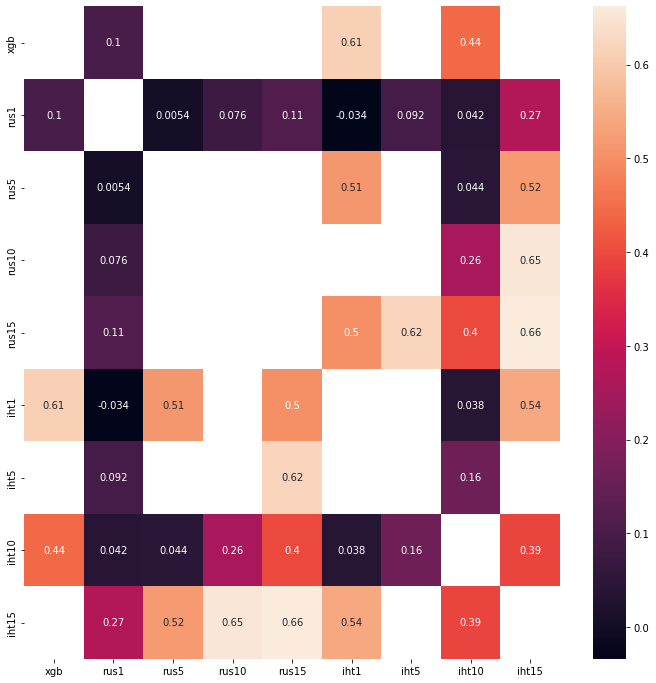

In [86]:
plt.rcParams['figure.figsize'] = (12 , 12)
snsfilter = sns.heatmap(shap_importance.corr(method = 'spearman')[(shap_importance.corr(method = 'spearman') <= shap_thre)],
            annot=True);

### 6.2.3  SHAP feature importance visualisation

In [87]:
#select top 10 features for original xgb
shap_top10 = shap_importance.sort_values(['xgb'], ascending=[False])
shap_top10 = shap_top10.head(10)
shap_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
7,existingchecking,0.031,0.017,0.105,0.040,0.042,0.071,0.087,0.000,0.015
8,credithistory,0.009,0.003,0.019,0.008,0.014,0.003,0.014,0.002,0.009
9,purpose,0.008,0.000,0.021,0.006,0.010,0.007,0.039,0.000,0.002
0,creditamount,0.006,0.000,0.015,0.007,0.004,0.046,0.058,0.000,0.009
4,age,0.006,0.000,0.021,0.011,0.012,0.042,0.024,0.001,0.002
17,job,0.005,0.000,0.024,0.008,0.006,0.012,0.004,0.000,0.000
1,duration,0.004,0.000,0.002,0.001,0.002,0.038,0.013,0.002,0.001
2,installmentrate,0.003,0.000,0.002,0.002,0.002,0.063,0.001,0.000,0.000
15,otherinstallmentplans,0.003,0.000,0.003,0.002,0.005,0.000,0.000,0.001,0.000
14,property,0.002,0.000,0.008,0.003,0.002,0.017,0.002,0.000,0.001


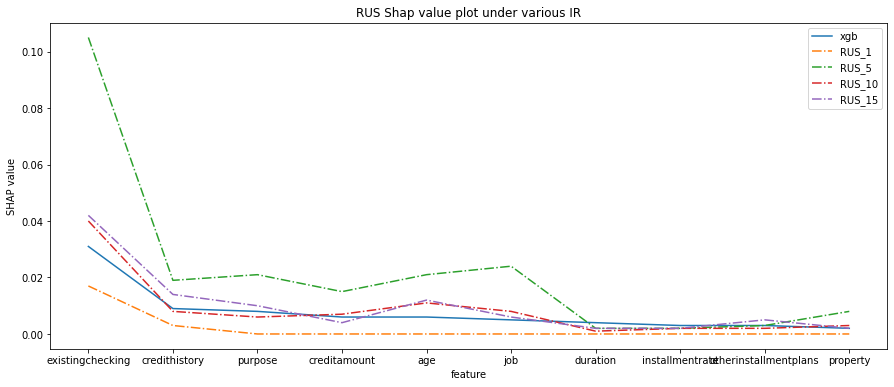

In [88]:
#1.aggeragate by approaches
#rus under different IRs
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
rus_1 =shap_top10['rus1'].tolist()
rus_5 =shap_top10['rus5'].tolist()
rus_10 =shap_top10['rus10'].tolist()
rus_15 =shap_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('RUS Shap value plot under various IR')
plt.show()

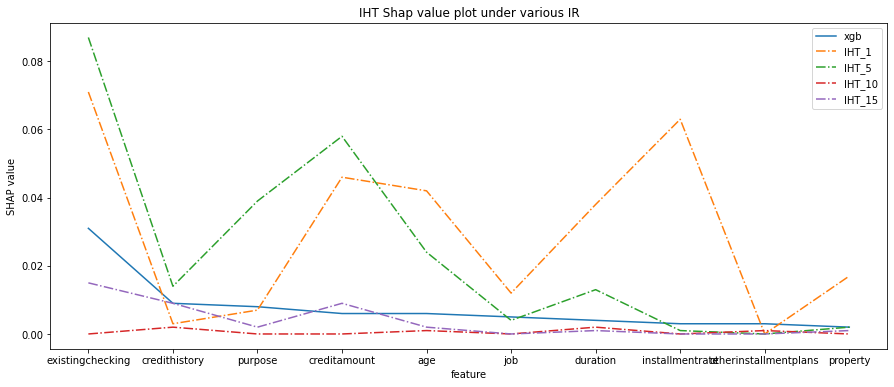

In [89]:
#iht under different IRs
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
iht_1 =shap_top10['iht1'].tolist()
iht_5 =shap_top10['iht5'].tolist()
iht_10 =shap_top10['iht10'].tolist()
iht_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('IHT Shap value plot under various IR')
plt.show()

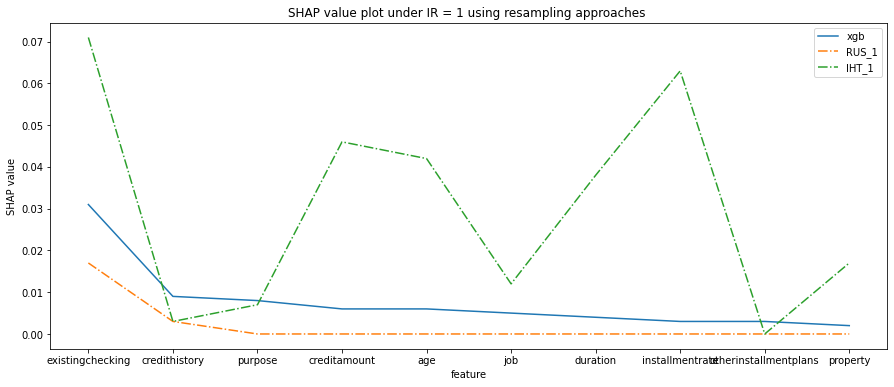

In [90]:
#aggeragate by IR
#IR=1 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_1 =shap_top10['rus1'].tolist()
IHT_1 =shap_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 1 using resampling approaches ')
plt.show()

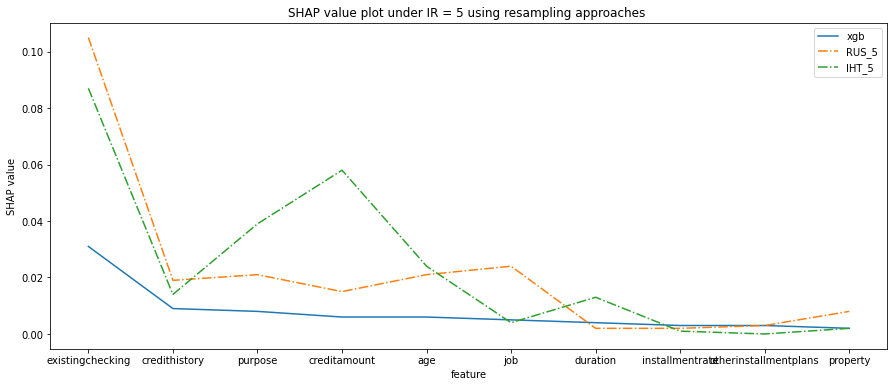

In [91]:
#IR=5 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_5 =shap_top10['rus5'].tolist()
IHT_5 =shap_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 5 using resampling approaches ')
plt.show()

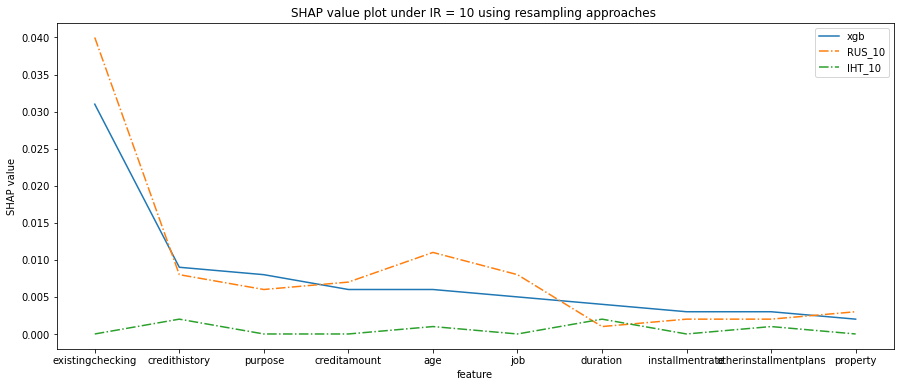

In [92]:
#IR=10 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_10 =shap_top10['rus10'].tolist()
IHT_10 =shap_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 10 using resampling approaches ')
plt.show()

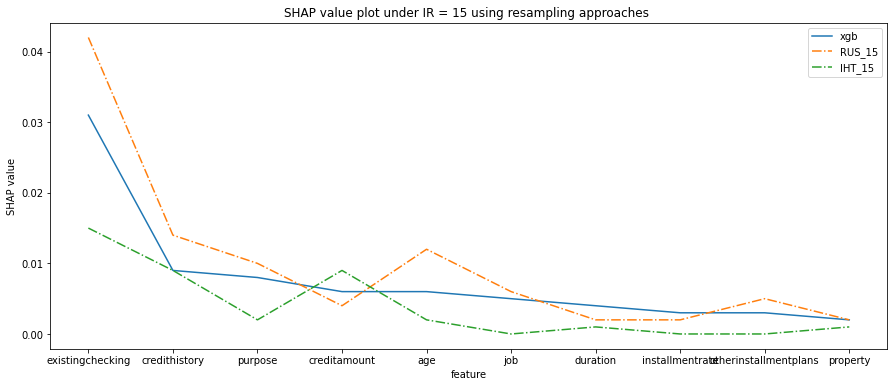

In [93]:
#IR=15 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_15 =shap_top10['rus15'].tolist()
IHT_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 15 using resampling approaches ')
plt.show()

## 6.3 PFI

### 6.3.1 Calculate PFI

In [94]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
pfi_xgb = permutation_importance(xgb_tune, X_train_final, y_train, scoring='roc_auc', n_repeats=5, random_state=1)
pfi_importance = pd.concat([pd.DataFrame(X_train_final.columns),pd.DataFrame(pfi_xgb.importances_mean.round(3))],axis = 1)
pfi_importance = pfi_importance.set_axis(['feature','xgb'], axis='columns')
pfi_importance.head()

,feature,xgb
0,creditamount,0.014
1,duration,0.012
2,installmentrate,0.003
3,residencesince,-0.001
4,age,0.018


In [95]:
def pfi_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [ ]:
pfi_list = pfi_generator(RE_Xlist, RE_ylist,xgb_tune)

In [97]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
pfi_importance['rus1'] = pfi_list[0]
pfi_importance['rus5'] = pfi_list[1]
pfi_importance['rus10'] = pfi_list[2]
pfi_importance['rus15'] = pfi_list[3]
pfi_importance['iht1'] = pfi_list[4]
pfi_importance['iht5'] = pfi_list[5]
pfi_importance['iht10'] = pfi_list[6]
pfi_importance['iht15'] = pfi_list[7]

pfi_importance.head()

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,creditamount,0.014,0.0,0.012,0.010,0.008,0.014,0.049,0.000,0.026
1,duration,0.012,0.0,0.002,-0.000,0.006,0.013,0.008,0.057,0.001
2,installmentrate,0.003,0.0,0.003,0.004,0.003,0.029,0.000,0.000,0.000
3,residencesince,-0.001,0.0,0.002,0.000,-0.000,0.000,0.002,0.000,0.000
4,age,0.018,0.0,0.031,0.050,0.027,0.018,0.020,0.008,0.025


In [98]:
pfi_importance.to_csv(path + '/pfi_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.3.2 PFI rank correlation

In [99]:
rank_pfi = pfi_importance.corr(method = 'spearman').round(3)
print(rank_pfi)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.144  0.719  0.852  0.931  0.573  0.698  0.483  0.683
rus1   0.144  1.000  0.021  0.148  0.083 -0.043  0.042  0.061  0.312
rus5   0.719  0.021  1.000  0.845  0.734  0.476  0.788  0.085  0.586
rus10  0.852  0.148  0.845  1.000  0.819  0.554  0.663  0.225  0.590
rus15  0.931  0.083  0.734  0.819  1.000  0.456  0.630  0.503  0.683
iht1   0.573 -0.043  0.476  0.554  0.456  1.000  0.556  0.084  0.564
iht5   0.698  0.042  0.788  0.663  0.630  0.556  1.000  0.193  0.741
iht10  0.483  0.061  0.085  0.225  0.503  0.084  0.193  1.000  0.382
iht15  0.683  0.312  0.586  0.590  0.683  0.564  0.741  0.382  1.000


In [100]:
rank_pfi.to_csv(path + '/rank_pfi.csv', index = True, encoding = 'utf-8-sig') 

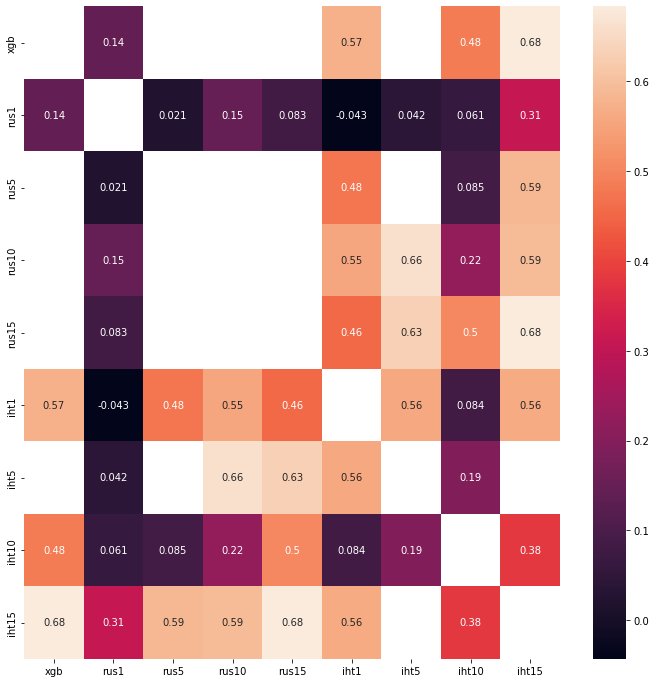

In [101]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(pfi_importance.corr(method = 'spearman')[(pfi_importance.corr(method = 'spearman') <= pfi_thre)],
            annot=True);

### 6.3.3 PFI feature importance visualisation

In [102]:
#select top 10 features for original xgb
pfi_top10 = pfi_importance.sort_values(['xgb'], ascending=[False])
pfi_top10 = pfi_top10.head(10)
pfi_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
7,existingchecking,0.235,0.233,0.286,0.225,0.244,0.076,0.201,0.000,0.167
8,credithistory,0.035,0.023,0.021,0.036,0.026,0.000,0.006,0.049,0.057
4,age,0.018,0.000,0.031,0.050,0.027,0.018,0.020,0.008,0.025
0,creditamount,0.014,0.000,0.012,0.010,0.008,0.014,0.049,0.000,0.026
17,job,0.013,0.000,0.034,0.025,0.008,0.002,0.002,0.000,0.000
9,purpose,0.012,0.000,0.013,0.014,0.013,0.002,0.031,0.000,0.007
1,duration,0.012,0.000,0.002,-0.000,0.006,0.013,0.008,0.057,0.001
15,otherinstallmentplans,0.005,0.000,0.001,0.004,0.013,0.000,0.000,0.031,-0.000
16,housing,0.004,0.000,0.004,0.019,0.002,0.008,0.008,0.000,0.000
2,installmentrate,0.003,0.000,0.003,0.004,0.003,0.029,0.000,0.000,0.000


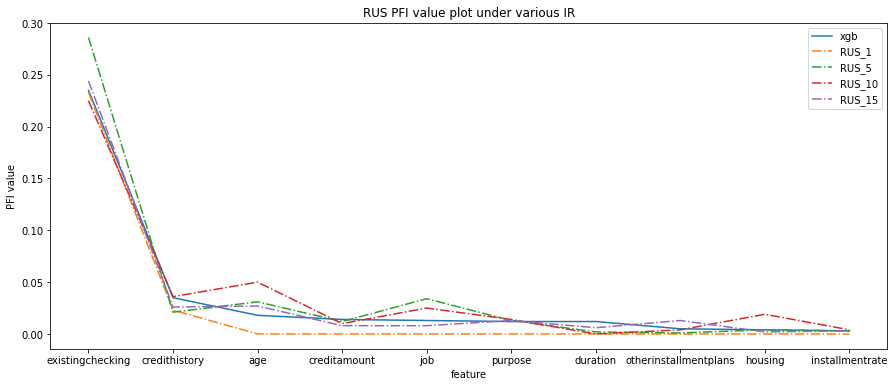

In [103]:
#aggeragate by approaches
#rus under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
rus_1 =pfi_top10['rus1'].tolist()
rus_5 =pfi_top10['rus5'].tolist()
rus_10 =pfi_top10['rus10'].tolist()
rus_15 =pfi_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('RUS PFI value plot under various IR')
plt.show()

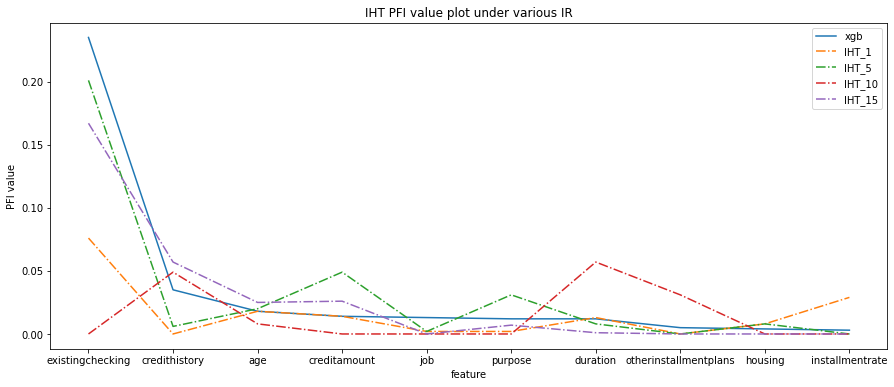

In [104]:
#iht under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
iht_1 =pfi_top10['iht1'].tolist()
iht_5 =pfi_top10['iht5'].tolist()
iht_10 =pfi_top10['iht10'].tolist()
iht_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('IHT PFI value plot under various IR')
plt.show()

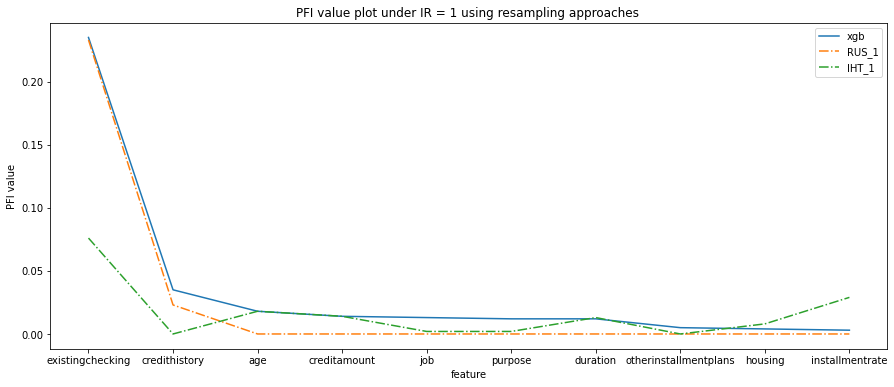

In [105]:
#aggeragate by IR
#IR=1 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_1 =pfi_top10['rus1'].tolist()
IHT_1 =pfi_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 1 using resampling approaches ')
plt.show()

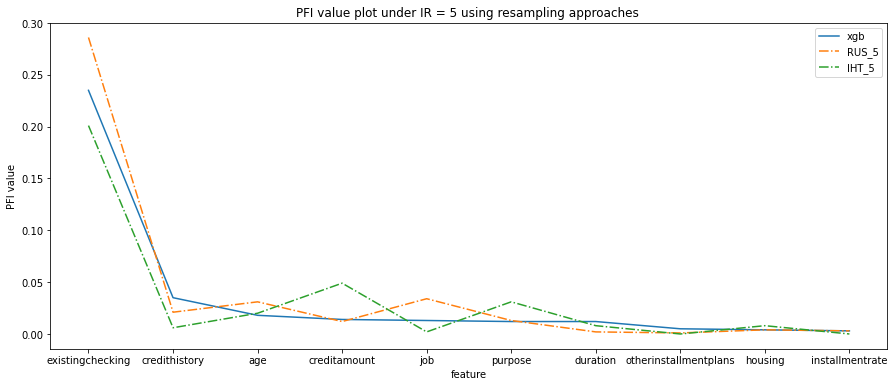

In [106]:
#IR=5 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_5 =pfi_top10['rus5'].tolist()
IHT_5 =pfi_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 5 using resampling approaches ')
plt.show()


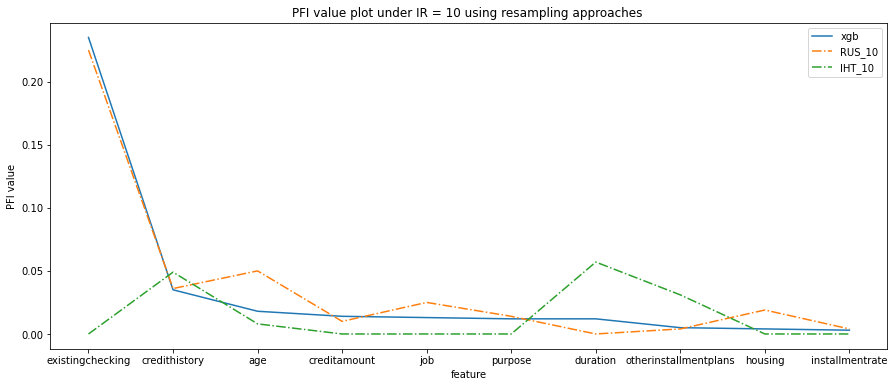

In [107]:
#IR=10 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_10 =pfi_top10['rus10'].tolist()
IHT_10 =pfi_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 10 using resampling approaches ')
plt.show()


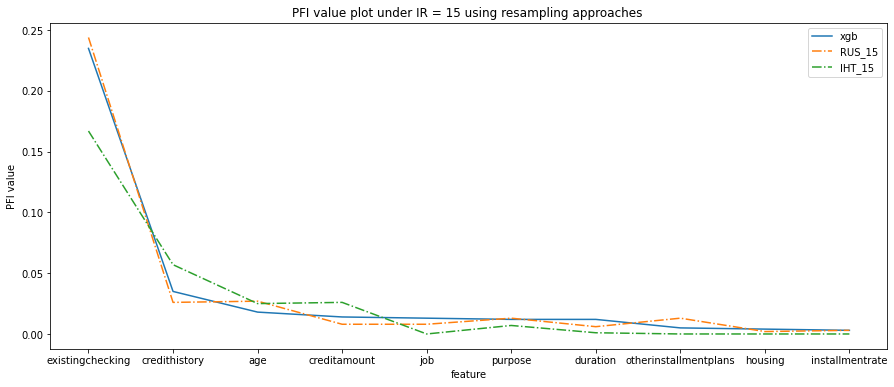

In [108]:
#IR=15 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_15 =pfi_top10['rus15'].tolist()
IHT_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 15 using resampling approaches ')
plt.show()
